#**Neurodegenerative Disordert Detection**<br>
Implementing a Neurodegenerative Disorder Detection system using YOLOv8. Curate a diverse dataset, annotate images, and train models for accurate detection. Emphasizing ethical healthcare data usage, this project seeks robust precision and recall in identifying brain tumors through the YOLOv8 along with different sizes and optimizers.

## **Data Collection**

The dataset merges ADNI and Mayo Clinic MRI/PET scans from Alzheimer’s, Parkinson’s, frontotemporal dementia, and healthy controls. Preprocessed for uniformity with skull stripping and intensity normalization, it includes manually annotated disease regions. Used to train the YOLOv8 model, it boosts early detection accuracy and generalization across diverse neurodegenerative conditions.

## Importing Libraries

In [ ]:
!pip install Augmentor
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 861.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

In [ ]:
zip_path = '/content/drive/MyDrive/NDD_Dataset.zip'
extract_path = '/content/drive/MyDrive'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

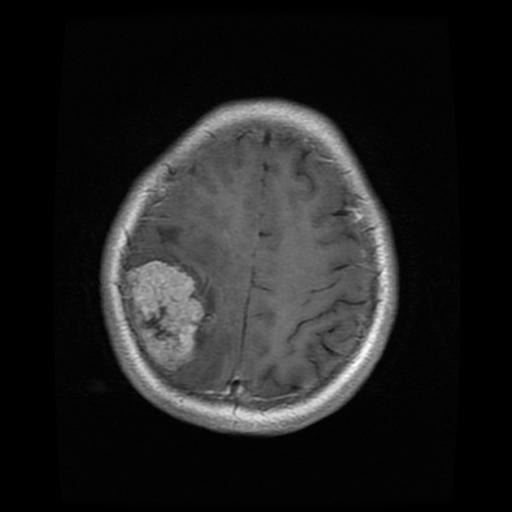

In [ ]:
sample_image = Image.open('/content/drive/MyDrive/NDD_Dataset/AD/Tr-me_0011.jpg')
sample_image

In [ ]:
sample_image.size

(512, 512)

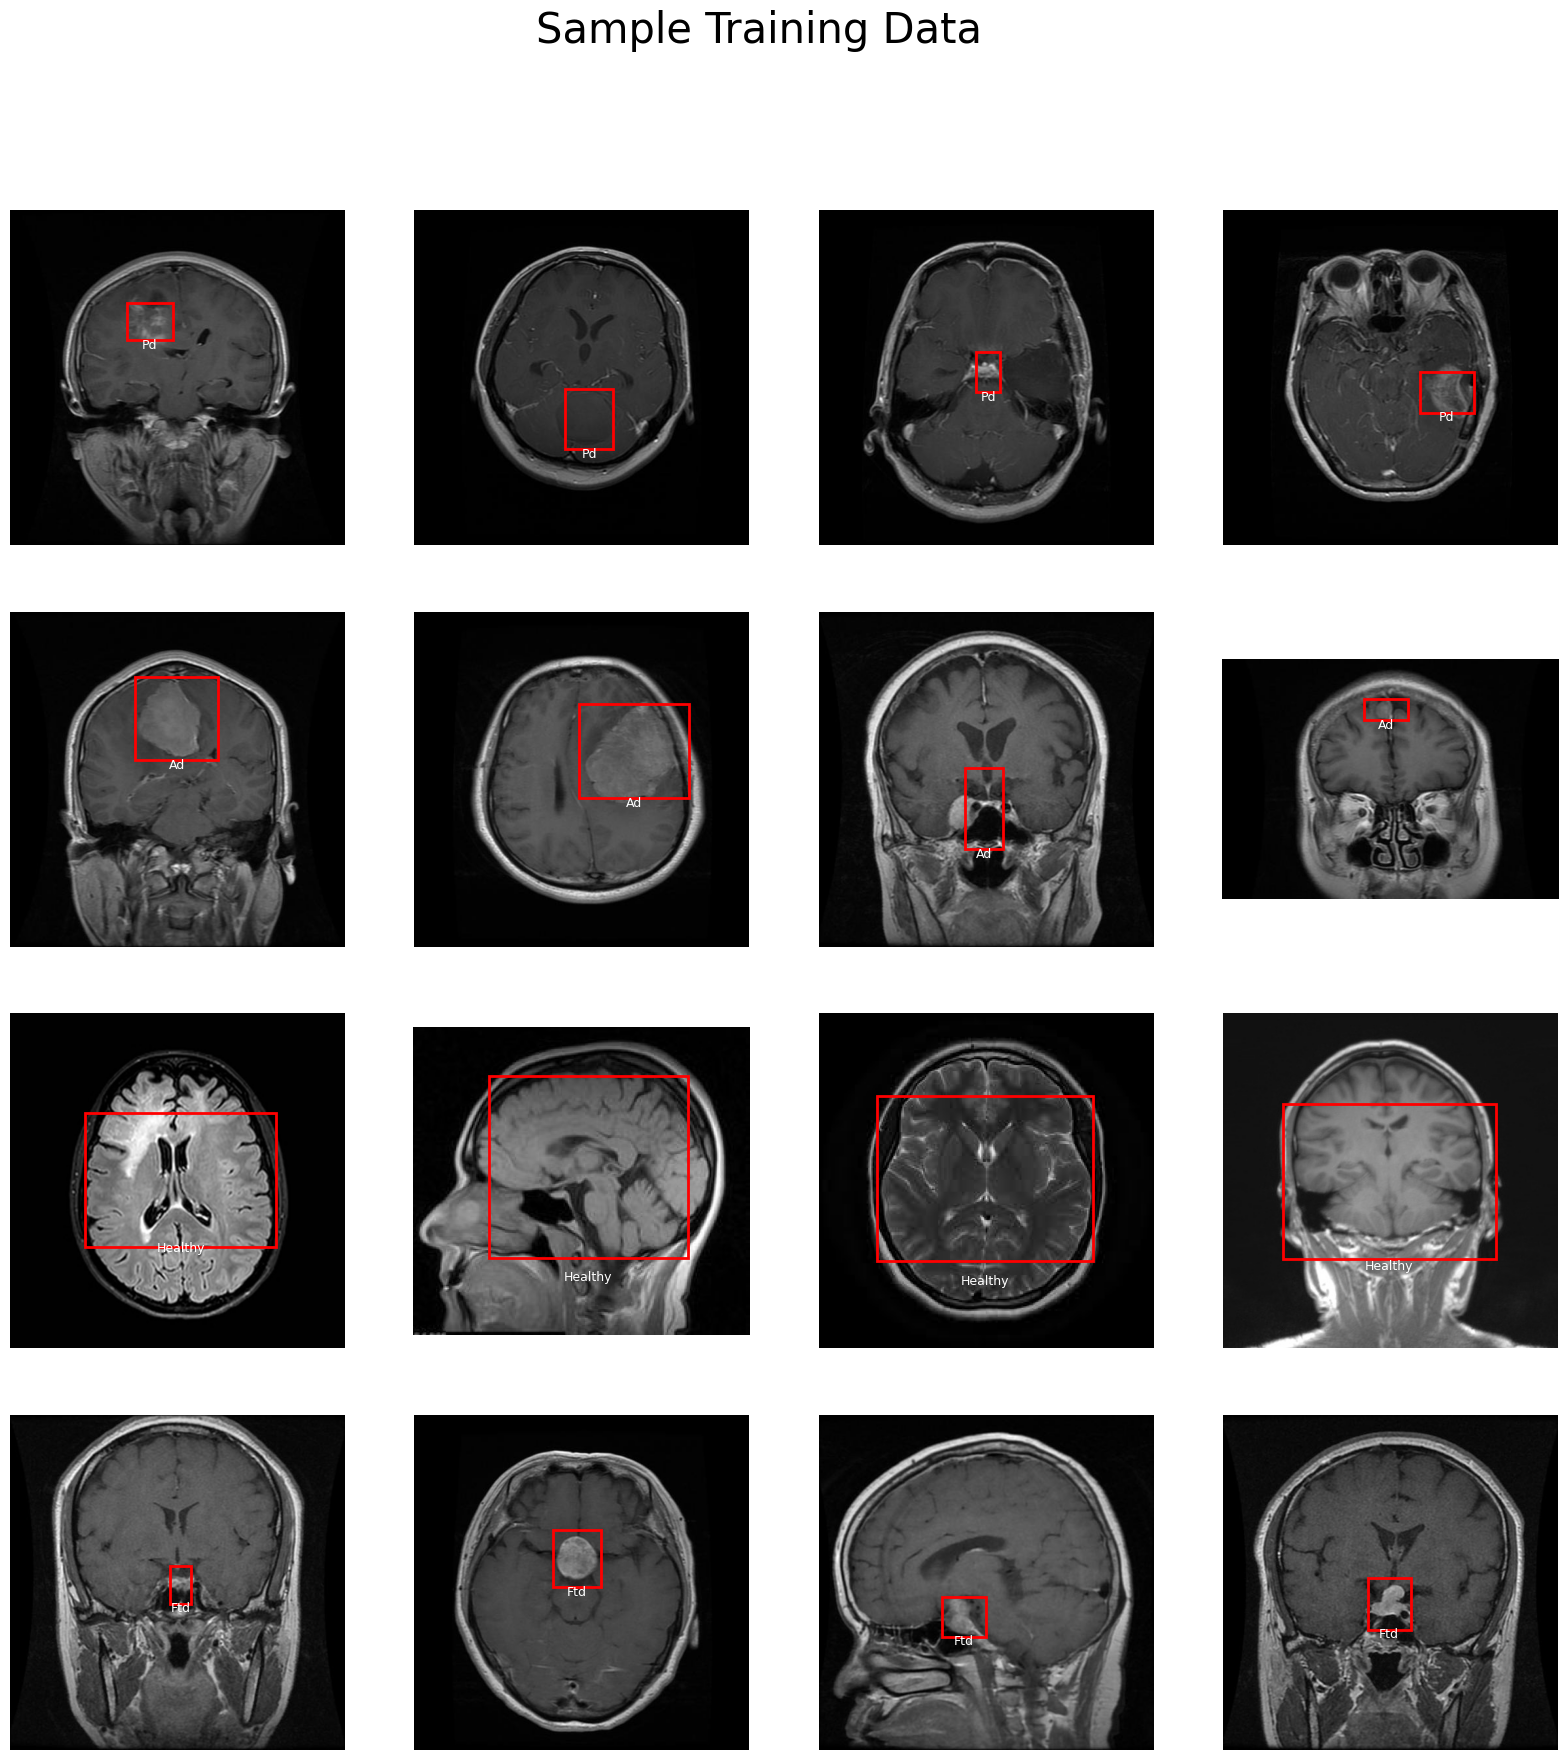

In [ ]:
# Plotting the training data with bounding boxes
dataset_directory = '/content/drive/MyDrive/NDD_Dataset'
class_labels = {'PD': 0, 'AD': 1, 'Healthy': 2, 'FTD': 3}

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for class_name, ax_row in zip(class_labels.keys(), axes):
    class_directory = os.path.join(dataset_directory, class_name)
    image_files = [f for f in os.listdir(class_directory) if f.endswith('.jpg')]
    selected_images = random.sample(image_files, 4)

    for ax, image_file in zip(ax_row, selected_images):
        annotation_file = os.path.join(class_directory, image_file.replace('.jpg', '.txt'))
        with open(annotation_file, 'r') as file:
            line = file.readline().strip().split()
            class_number, centre_x, centre_y, height, width = map(float, line)

        img = plt.imread(os.path.join(class_directory, image_file))

        if len(img.shape) == 2:
            img = np.stack((img,) * 3, axis=-1)

        img_height, img_width, _ = img.shape
        x_min = (centre_x - width / 2) * img_width
        y_min = (centre_y - height / 2) * img_height
        x_max = (centre_x + width / 2) * img_width
        y_max = (centre_y + height / 2) * img_height
        tumor_bbox = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none', label=f'{class_name.capitalize()}')
        ax.imshow(img)
        ax.add_patch(tumor_bbox)

        label_text = f'{class_name.capitalize()}'
        ax.text((x_min + x_max) / 2, y_max + 18, label_text, color='w', ha='center', va='bottom', fontsize=9)

for ax_row in axes:
    for ax in ax_row:
        ax.axis('off')

plt.suptitle("Sample Training Data", fontsize=30)
plt.show()

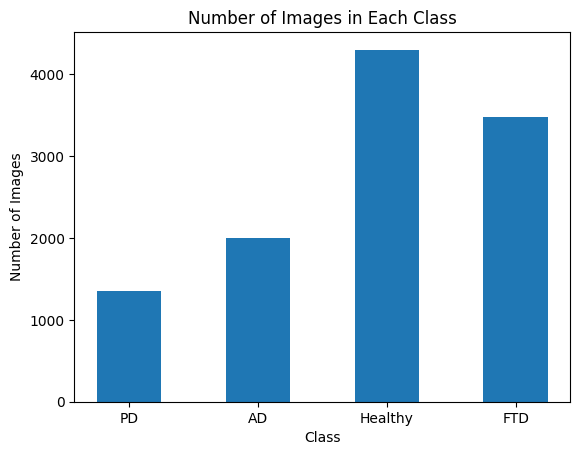

In [ ]:
class_names = ['PD', 'AD', 'Healthy', 'FTD']
class_counts = [1357, 1996, 4300, 3480]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()

## Train-Test Split

In [ ]:
def custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-test split on an image dataset.
    This function organizes the dataset into 'train' and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train' and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    train_directory = os.path.join(dataset_directory, 'train')
    test_directory = os.path.join(dataset_directory, 'test')
    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        if len(image_files) < min_samples_per_class:
            continue

        train_images, test_images = train_test_split(image_files, test_size=test_ratio, random_state=random_seed)

        for train_image in train_images:
            src_image_path = os.path.join(class_path, train_image)
            src_annotation_path = os.path.join(class_path, train_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, train_image)
            dest_annotation_path = os.path.join(train_directory, class_dir, train_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        for test_image in test_images:
            src_image_path = os.path.join(class_path, test_image)
            src_annotation_path = os.path.join(class_path, test_image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, test_image)
            dest_annotation_path = os.path.join(test_directory, class_dir, test_image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

In [ ]:
dataset_directory = '/content/drive/MyDrive/NDD_Dataset'
custom_train_test_split(dataset_directory, test_ratio=0.2, random_seed=42, min_samples_per_class=2)

In [ ]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts

In [ ]:
def plot_image_counts(train_directory, test_directory):
    """
    Plot the number of images in each class for both the training and testing sets.
    This function counts the number of images in each class for both the training and testing sets
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    test_counts_values = [test_counts[class_name] for class_name in class_names]

    bar_width = 0.35
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train and Test Sets')
    ax.set_xticks([i + bar_width/2 for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()

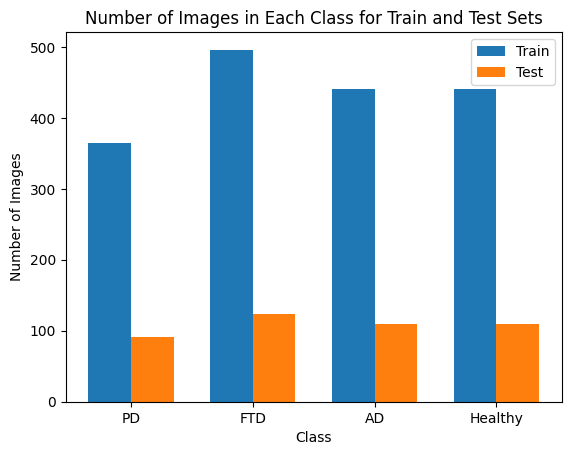

In [ ]:
dataset_directory = '/content/drive/MyDrive/NDD_Dataset'
train_directory = os.path.join(dataset_directory, 'train')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, test_directory)

## YOLOv8n

### Modelling

In [ ]:
yolo_btd_model = YOLO('yolov8n.yaml')

yolo_btd_model_results = yolo_btd_model.train(data='/content/drive/MyDrive/NDD_Dataset/brain_tumor_dataset.yaml', epochs=25)

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/NDD_Dataset/brain_tumor_dataset.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

100%|██████████| 755k/755k [00:00<00:00, 94.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 225MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/NDD_Dataset/train/AD... 1740 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1740/1740 [00:25<00:00, 69.34it/s] 


train: New cache created: /content/drive/MyDrive/NDD_Dataset/train/AD.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/NDD_Dataset/test/AD... 435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 435/435 [00:05<00:00, 74.02it/s]


val: New cache created: /content/drive/MyDrive/NDD_Dataset/test/AD.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.04G      3.374      5.104      4.112         16        640: 100%|██████████| 109/109 [00:45<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


                   all        435        439   0.000729      0.214    0.00849    0.00202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      1.99G      2.972      4.468      3.476         28        640: 100%|██████████| 109/109 [00:44<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


                   all        435        439      0.537     0.0885     0.0423      0.014

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.07G      2.647      3.662      2.968         18        640: 100%|██████████| 109/109 [00:42<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


                   all        435        439      0.391      0.164      0.119     0.0414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      1.99G      2.447      3.204      2.745         18        640: 100%|██████████| 109/109 [00:41<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.01it/s]


                   all        435        439       0.41      0.306      0.179     0.0663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.07G      2.243      2.789      2.546         22        640: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

                   all        435        439      0.563        0.4      0.377      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      1.99G      2.146      2.501      2.425         15        640: 100%|██████████| 109/109 [00:45<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


                   all        435        439      0.647      0.479      0.526      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      1.99G      2.036      2.306      2.322         19        640: 100%|██████████| 109/109 [00:44<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.41it/s]

                   all        435        439      0.627      0.493      0.525      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      1.99G      1.951      2.101      2.256         19        640: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


                   all        435        439      0.681      0.496      0.573      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.06G      1.887      1.961      2.183         25        640: 100%|██████████| 109/109 [00:40<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

                   all        435        439      0.707      0.543      0.611      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      1.99G      1.815       1.85      2.111         24        640: 100%|██████████| 109/109 [00:40<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.25it/s]

                   all        435        439      0.717      0.627      0.662      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      1.99G      1.774      1.753      2.051         18        640: 100%|██████████| 109/109 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.40it/s]

                   all        435        439      0.678      0.643      0.677       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      1.99G      1.764      1.724      2.046         19        640: 100%|██████████| 109/109 [00:41<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

                   all        435        439      0.753      0.634      0.712      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.06G      1.721       1.65      2.015         22        640: 100%|██████████| 109/109 [00:39<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.08it/s]

                   all        435        439      0.734      0.676      0.737       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      1.99G      1.686      1.578      1.979         17        640: 100%|██████████| 109/109 [00:40<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


                   all        435        439      0.713      0.681      0.725      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      1.99G      1.654      1.536      1.936         18        640: 100%|██████████| 109/109 [00:39<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]

                   all        435        439      0.772      0.646      0.743      0.418


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      1.99G      1.605      1.523      2.082         12        640: 100%|██████████| 109/109 [00:39<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.29it/s]


                   all        435        439      0.719      0.715      0.766       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.07G      1.573      1.413      2.055         12        640: 100%|██████████| 109/109 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]

                   all        435        439      0.753       0.75      0.788       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      1.99G      1.544      1.303      1.989         12        640: 100%|██████████| 109/109 [00:35<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

                   all        435        439      0.805      0.744      0.794      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      1.99G      1.531      1.288      1.991         12        640: 100%|██████████| 109/109 [00:36<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]

                   all        435        439      0.842      0.739      0.811      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      1.99G      1.511      1.236       1.96         12        640: 100%|██████████| 109/109 [00:37<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

                   all        435        439      0.839      0.719      0.818      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.06G        1.5      1.212      1.955         12        640: 100%|██████████| 109/109 [00:37<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]

                   all        435        439      0.833      0.756      0.817       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      1.99G      1.479      1.167      1.931         12        640: 100%|██████████| 109/109 [00:38<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

                   all        435        439      0.832      0.763      0.834      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      1.99G      1.473      1.139      1.926         12        640: 100%|██████████| 109/109 [00:38<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]

                   all        435        439      0.852      0.774      0.839      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      1.99G      1.451      1.113      1.905         12        640: 100%|██████████| 109/109 [00:37<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

                   all        435        439      0.838      0.791       0.85      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.06G      1.421      1.093      1.891         12        640: 100%|██████████| 109/109 [00:36<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.12it/s]


                   all        435        439      0.841      0.789      0.851      0.503

25 epochs completed in 0.331 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


                   all        435        439      0.841      0.791       0.85      0.505
                    PD        124        124      0.867      0.946      0.918      0.468
                    AD        110        110      0.881      0.855      0.936       0.55
               Healthy         92         96      0.741      0.438        0.6      0.308
                   FTD        109        109      0.874      0.927      0.948      0.693
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


### Performance Metrics

In [ ]:
def plot_images(image_paths):
    num_images = len(image_paths)
    images_per_row = 3  # Set to 3 images per row
    num_rows = math.ceil(num_images / images_per_row)  # Compute required rows

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 20))

    # Flatten axes if multiple rows exist
    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, ax in enumerate(axes):
        if i < num_images:
            img = mpimg.imread(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(image_paths[i]))
        else:
            ax.axis('off')  # Hide empty subplot spaces

    plt.tight_layout()
    plt.show()

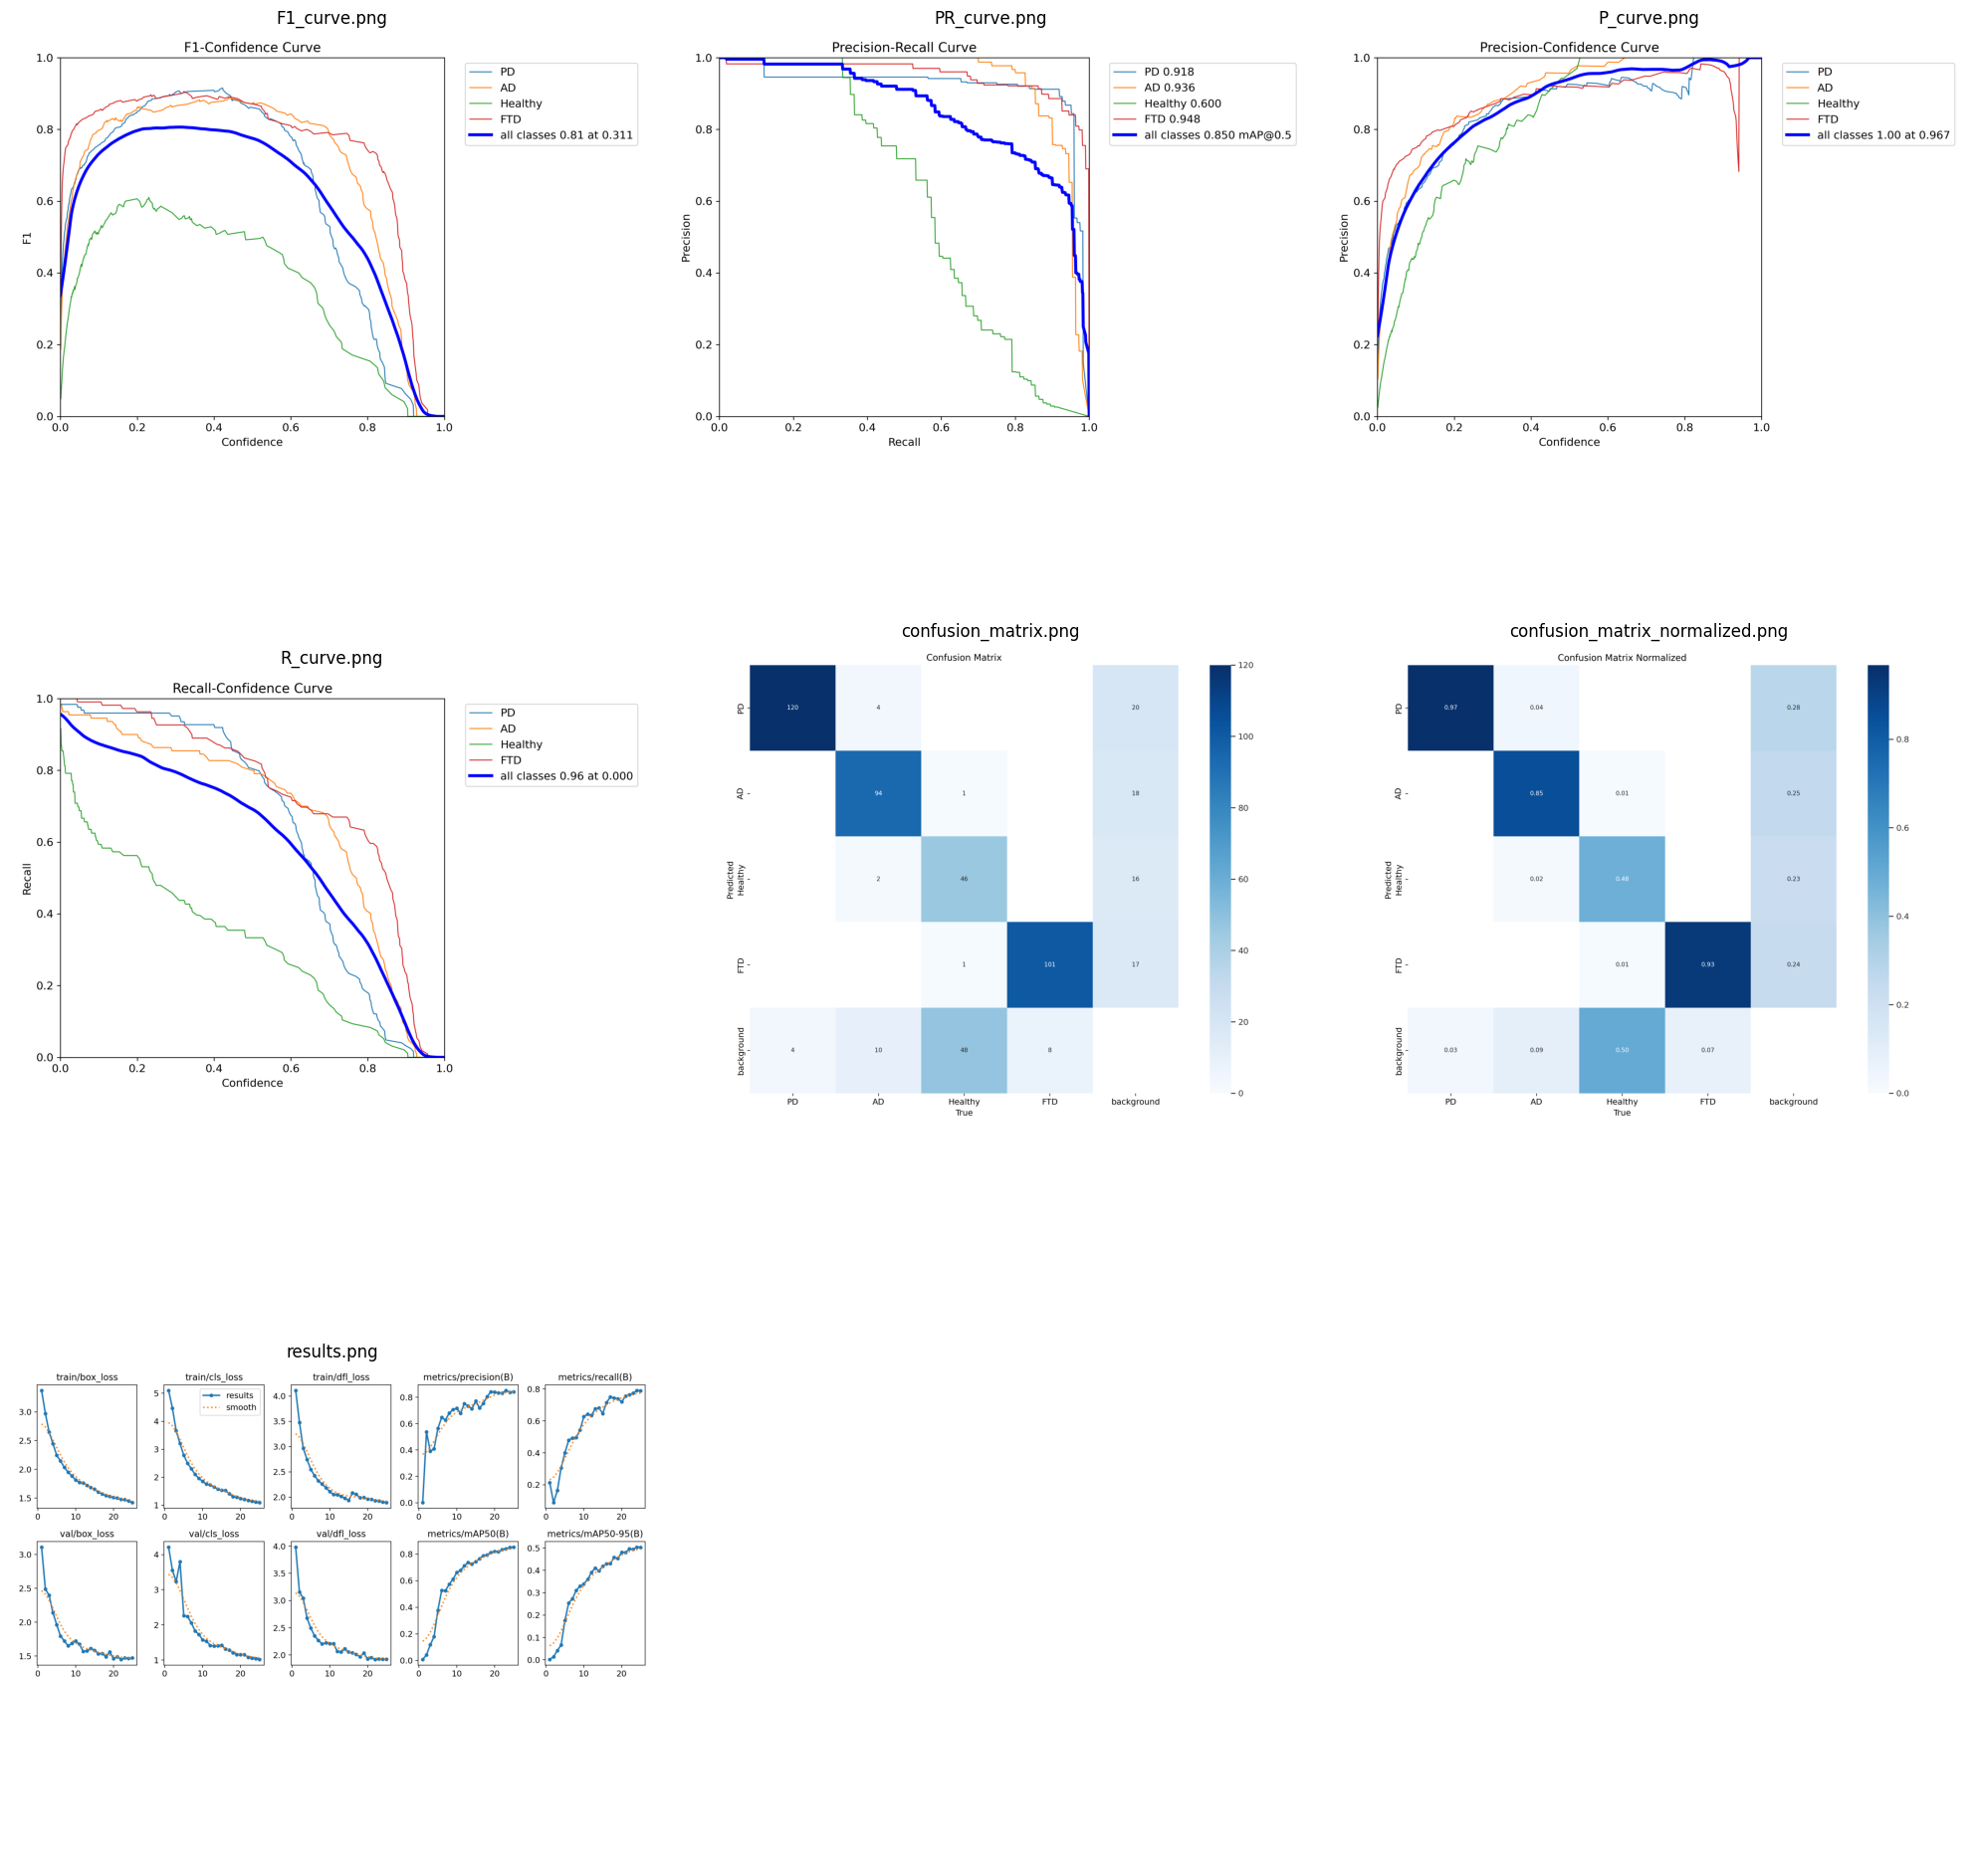

In [ ]:
image_paths = [
    '/content/drive/MyDrive/runs/detect/train/F1_curve.png',
    '/content/drive/MyDrive/runs/detect/train/PR_curve.png',
    '/content/drive/MyDrive/runs/detect/train/P_curve.png',
    '/content/drive/MyDrive/runs/detect/train/R_curve.png',
    '/content/drive/MyDrive/runs/detect/train/confusion_matrix.png',
    '/content/drive/MyDrive/runs/detect/train/confusion_matrix_normalized.png',
    '/content/drive/MyDrive/runs/detect/train/results.png',
]
plot_images(image_paths)

### Testing

In [ ]:
def predict_results(test_images_dir, output_dir='/content/drive/MyDrive/predictions'):
    model = YOLO('/content/drive/MyDrive/runs/detect/train/weights/best.pt')

    # Define output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get image files
    image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(test_images_dir, image_file)

        # Perform prediction and save results in the specified output directory
        model.predict(image_path, save=True, imgsz=320, conf=0.3, project=output_dir)

In [ ]:
PD_test_dir = '/content/drive/MyDrive/NDD_Dataset/test/PD'
predict_results(PD_test_dir)


image 1/1 /content/drive/MyDrive/NDD_Dataset/NDD_Dataset/test/PD/Tr-gl_0559.jpg: 320x320 (no detections), 11.8ms
Speed: 1.7ms preprocess, 11.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/predictions/predict

image 1/1 /content/drive/MyDrive/NDD_Dataset/NDD_Dataset/test/PD/Tr-gl_0405.jpg: 320x320 (no detections), 17.9ms
Speed: 2.3ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/predictions/predict2

image 1/1 /content/drive/MyDrive/NDD_Dataset/NDD_Dataset/test/PD/Tr-gl_0377.jpg: 320x320 1 Normal, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/drive/MyDrive/predictions/predict3

image 1/1 /content/drive/MyDrive/NDD_Dataset/NDD_Dataset/test/PD/Tr-gl_0376.jpg: 320x320 1 AD, 1 Normal, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1,